# Predicting Risk of Lead Poisoning in NYC


## Introduction

Exposure to lead poses a significant danger to public health.  Young children are most vulnerable to the detrimental effects of lead poisoning:  elevated blood lead levels (BLL) in this population are associated with early neurological development issues, neuropsychiatric disorders, lowered IQs, and in extreme cases, death.  Significant effort has been dedicated to the elimination of lead exposure over the last decades, and while cases of lead poisoning continue to decline the problem is far from being eradicated.  Local authorities across the United States struggle to dedicate resources for risk evaluation, preventative measures, as well as remediation in cases where lead is found.  In order to optimize the limited budgets of local departments of health, it is crucial to identify neighborhoods most at risk and to target families within these areas for testing, preventative education and intervention.

The question is how to evaluate the risk for lead poisoning and devise a consistent measure for determining which populations must be prioritized for most significant impact.  To answer this question, I collected data on numbers of one- and two-year-olds tested for lead, elevated BLL of children under six, as well as housing data related to lead exposure risk, such as buildings built prior to 1950, buildings with peeling paint, and other maintenance issues possibly correlated with risk.  The focus for the current analysis is on New York City (NYC) and all data is aggregated at the United Hospital Fund (UHF) Neighborhood scale, which consists of 42 adjoining zip code areas.

This report details some of the exploratory analysis performed on the data sets mentioned above, suggestions for predictive analytics to forecast risk in years to come, and thoughts about further data collection and analysis to be able to recommend intervention at the level of individual housing units, school buildings, and/or individual children.

## The Data

Childhood lead exposure data was collected from the nyc.gov Environment and Health Data Portal: http://a816-dohbesp.nyc.gov/IndicatorPublic/PublicTracking.aspx?theme_code=2,3&subtopic_id=14 and was sourced by the NYC Lead Poisoning Prevention Program (LPPP).  The housing data is also available through the portal, and was sourced by the NYC Housing and Vacancy Survey (NYCHVS), sponsored by the NYC Department of Housing Preservation and Development.  (A note about data collection:  while the nyc.gov data portal is a convenient place to search for disparate data sets, its contents are not yet optimally organized, cleaned or presented.  There are duplicate data sets and the site itself is still incomplete and under construction.  For example, in order to download the BLL data, I needed to open developer tools in the Chrome browser and change settings for the hidden 'Export to CSV' button to make it visible and functional.)

Before deciding to focus on NYC neighborhoods for analysis I wanted to assess areas in all of NY State for susceptibility to lead poisoning.  To this end, I collected county level lead data for NY from the Centers for Disease Control and Prevention (CDC) website:  http://www.cdc.gov/nceh/lead/data/state/nydata.htm   In the year 2014, several counties had significant numbers of poisoned lead results.  However - perhaps not surprisingly considering its high density population - NYC, by far had the greatest number of children with elevated bll:

https://jtsitron.cartodb.com/viz/393831da-e768-11e5-95ae-0e31c9be1b51/public_map
(please click on the link for interactive map)

Now, zooming into NYC neighborhods, we can get some intuition about where these cases have been concentrated during the years 2005-2014 (years for which data is available on the portal):

https://jtsitron.cartodb.com/viz/7e2076b8-e76d-11e5-9db1-0e31c9be1b51/public_map

Ideally, we would like to see how these numbers have been changing over the years.  Unfortunately, CartoDB has not yet implemented the spatio-temporal feature for polygon geometries, but we can visualize how numbers of positive test results have declined in each neighborhood by building some simple graphs.  In the following cells, we import the BLL data and plot some trends.  "Positive" results indicate BLL >= 5 µg/dL.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
import numpy as np
import pandas as pd

In [13]:
df = pd.read_csv('/home/jtsitr/data_challenges/Arnhold/bll/bll_3_10_aftersql.csv')
del df['Unnamed: 11']
del df['Num. children < 6 w/ blood lead levels >= 5 mcg/dL (number)']
del df['Perc. children < 6 w/blood lead levels >= 5 mcg/dL (percent)']
del df['Num. children < 6 w/blood lead levels >= 10 mcg/dL (number)']
del df['Rate children < 6 w/blood lead levels >= 10 mcg/dL (per 1,000 tested)']

A quick peek at what the data looks like:

In [14]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 0 to 377
Data columns (total 7 columns):
index                      378 non-null int64
Year                       378 non-null int64
borough                    378 non-null object
geography                  378 non-null object
geography_id               378 non-null int64
Number                     378 non-null int64
Rate (per 1,000 tested)    378 non-null float64
dtypes: float64(1), int64(4), object(2)

,index,Year,borough,geography,geography_id,Number,"Rate (per 1,000 tested)"
0,1,2005,Queens,Bayside - Little Neck,404,103,53.3
1,2,2006,Queens,Bayside - Little Neck,404,80,42.0
2,3,2007,Queens,Bayside - Little Neck,404,86,43.5
3,4,2008,Queens,Bayside - Little Neck,404,65,29.8
4,5,2009,Queens,Bayside - Little Neck,404,63,28.6


We can look at the trends expressed as the proportion of all tests that were positive (each line represents a neighborhood) : 

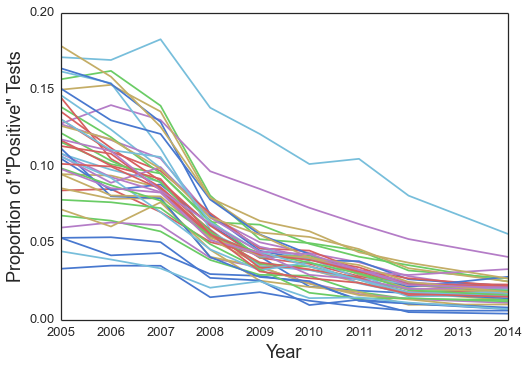

In [9]:
for key, grp in df.groupby(['geography']):
    plt.plot(grp['Year'], grp['Rate (per 1,000 tested)']/1000.)
    plt.xticks( fontsize = 13) 
    plt.xlabel('Year', fontsize = 18) 
    plt.yticks( fontsize = 13) 
    plt.ylabel('Proportion of "Positive" Tests', fontsize = 18) 
    ax = plt.gca()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)

Or, as the total number of positive test results: 

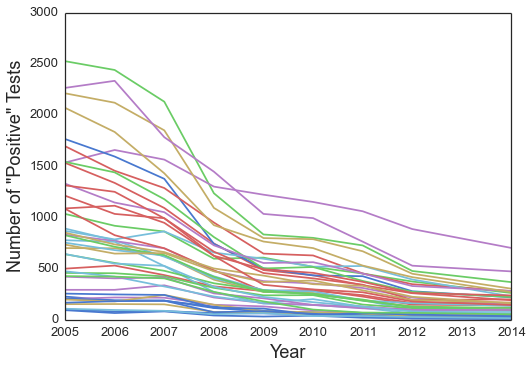

In [10]:
for key, grp in df.groupby(['geography']):
    plt.plot(grp['Year'], grp['Number'])
    plt.xticks( fontsize = 13) 
    plt.xlabel('Year', fontsize = 18) 
    plt.yticks( fontsize = 13) 
    plt.ylabel('Number of "Positive" Tests', fontsize = 18) 
    ax = plt.gca()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)

## Proposed Methods and Recommendations for Further analysis

Clearly, lead poisoning cases have been declining over the years.  The goal now is to rank which neighborhoods remain at greatest risk in future years so that efforts can be concentrated in places where largest numbers of positive test results are expected.  The plan is to look at additional data that can inform our predictions and build a time-dependent regression model to predict number of positive results for each neighborhood based on history of lead poisoning cases as well as housing features that are known to increase lead exposure. Specifically, the housing features included in our data set include:
-Pre-1950 Homes
-Pre-1960 Homes with Peeling Paint
-Children < 5 Years Old Living in Poverty
-Crowding
-Owner-Occupied Homes (perhaps negatively correlated)
-Homes with Cracks or Holes
-Homes with Leaks
-Homes near Buildings with Broken or Boarded Up Windows
-Homes in Deteriorating or Dilapidated Buildings
-Homes with 3 or More Maintenance Deficiencies
-Adults Reporting Mold in the Home

Given more time, I would deploy the autoregressive integrated moving average (ARIMA) model to forecast numbers of lead poisoning cases in each neighborhood.  Once a validated ranking is established for neighborhoods I would gather more data, perhaps at individual building level within the highest ranked neighborhoods.  The goal would be to discover high risk buildings or small areas where high risk buildings are clustered in order to recommend intervention for those targeted subneighborhoods.